# Интуиция принципа работы градиентного бустинга

Рассмотрим "игрушечный" пример того, как работает и обучается градиентный бустинг.

В данной демонстрации мы допускаем упрощения в угоду понятности и интуитивности. Первоочередная цель — это дать ответы на вопросы:
* Как пошагово обучается градиентный бустинг?
* Что получают на вход модели в градиентном бустинге?
* Что предсказывают модели в градиентном бустинге?
* Где градиент в градиентном бустинге?


Будем решать задачу регрессии. Для начала сгенерируем датасет: создадим 10 объектов с 3 признаками и целевой переменной.

In [ ]:
import numpy as np
from sklearn.datasets import make_regression

np.random.seed(0)
x, y = make_regression(n_samples=10, n_features=3)

In [ ]:
print(f"x.shape: {x.shape}\nx:\n {x}")

x.shape: (10, 3)
x:
 [[ 1.49407907 -0.20515826  0.33367433]
 [ 0.40015721  0.97873798  1.76405235]
 [ 0.12167502  0.44386323  0.76103773]
 [-0.15135721 -0.10321885  0.95008842]
 [ 0.14404357  1.45427351  0.4105985 ]
 [-0.85409574 -2.55298982  0.3130677 ]
 [ 0.8644362  -0.74216502  0.6536186 ]
 [ 1.53277921  1.46935877 -0.18718385]
 [ 1.86755799 -0.97727788  2.2408932 ]
 [-1.45436567  0.04575852  2.26975462]]


In [ ]:
print(f"y.shape: {y.shape}\ny:\n {y}")

y.shape: (10,)
y:
 [ 125.98419292  228.95203573   96.07607259   75.63377087  100.85361934
 -120.47027794   93.94272528  139.66716702  303.68384795  116.69110743]


Отобразим данные в `DataFrame` для наглядности:

In [ ]:
import pandas as pd

df = pd.DataFrame(x, columns=["feature_1", "feature_2", "feature_3"])
df["y_true"] = y

In [ ]:
df

,feature_1,feature_2,feature_3,y_true
0,1.494079,-0.205158,0.333674,125.984193
1,0.400157,0.978738,1.764052,228.952036
2,0.121675,0.443863,0.761038,96.076073
3,-0.151357,-0.103219,0.950088,75.633771
4,0.144044,1.454274,0.410599,100.853619
5,-0.854096,-2.552990,0.313068,-120.470278
6,0.864436,-0.742165,0.653619,93.942725
7,1.532779,1.469359,-0.187184,139.667167
8,1.867558,-0.977278,2.240893,303.683848
9,-1.454366,0.045759,2.269755,116.691107


**Шаг 0.**

Делаем самое первое предсказание, от которого сможем шагать дальше. Самое наивное, что можно сделать, — это предсказать среднее:

In [ ]:
df["y_pred_0"] = df["y_true"].mean()

In [ ]:
df

,feature_1,feature_2,feature_3,y_true,y_pred_0
0,1.494079,-0.205158,0.333674,125.984193,116.101426
1,0.400157,0.978738,1.764052,228.952036,116.101426
2,0.121675,0.443863,0.761038,96.076073,116.101426
3,-0.151357,-0.103219,0.950088,75.633771,116.101426
4,0.144044,1.454274,0.410599,100.853619,116.101426
5,-0.854096,-2.552990,0.313068,-120.470278,116.101426
6,0.864436,-0.742165,0.653619,93.942725,116.101426
7,1.532779,1.469359,-0.187184,139.667167,116.101426
8,1.867558,-0.977278,2.240893,303.683848,116.101426
9,-1.454366,0.045759,2.269755,116.691107,116.101426


Теперь посчитаем ошибку по всем объектам, будем использовать mean squared error:

 $\large \text{MSE} = \dfrac1n \sum\limits_{i=1}^{n}(x_i-y_i)^2$

In [ ]:
from sklearn.metrics import mean_squared_error

mse_0 = mean_squared_error(df["y_true"], df["y_pred_0"])

print(f"Iteration №0, mse: {mse_0}")

Iteration №0, mse: 10730.410671822861


**Шаг 1.**

Посчитаем градиент со знаком минус (антиградиент):

In [ ]:
df["-grad_0"] = -2*(df["y_pred_0"] - df["y_true"])

In [ ]:
df

,feature_1,feature_2,feature_3,y_true,y_pred_0,-grad_0
0,1.494079,-0.205158,0.333674,125.984193,116.101426,19.765534
1,0.400157,0.978738,1.764052,228.952036,116.101426,225.701219
2,0.121675,0.443863,0.761038,96.076073,116.101426,-40.050707
3,-0.151357,-0.103219,0.950088,75.633771,116.101426,-80.935310
4,0.144044,1.454274,0.410599,100.853619,116.101426,-30.495614
5,-0.854096,-2.552990,0.313068,-120.470278,116.101426,-473.143408
6,0.864436,-0.742165,0.653619,93.942725,116.101426,-44.317402
7,1.532779,1.469359,-0.187184,139.667167,116.101426,47.131482
8,1.867558,-0.977278,2.240893,303.683848,116.101426,375.164844
9,-1.454366,0.045759,2.269755,116.691107,116.101426,1.179363


**Шаг 2.**

Создадим простой предсказатель (возьмем дерево глубиной, равной единице). Обучим дерево восстанавливать антиградиент. Входные данные — наши признаки, целевая переменная — антиградиент.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_1 = DecisionTreeRegressor(max_depth=1)

tree_1.fit(df[["feature_1", "feature_2", "feature_3"]], df["-grad_0"])

DecisionTreeRegressor(max_depth=1)

Делаем предсказание нашего дерева:

In [ ]:
df["tree_pred_1"] = tree_1.predict(df[["feature_1", "feature_2", "feature_3"]])

In [ ]:
df

,feature_1,feature_2,feature_3,y_true,y_pred_0,-grad_0,tree_pred_1
0,1.494079,-0.205158,0.333674,125.984193,116.101426,19.765534,52.571490
1,0.400157,0.978738,1.764052,228.952036,116.101426,225.701219,52.571490
2,0.121675,0.443863,0.761038,96.076073,116.101426,-40.050707,52.571490
3,-0.151357,-0.103219,0.950088,75.633771,116.101426,-80.935310,52.571490
4,0.144044,1.454274,0.410599,100.853619,116.101426,-30.495614,52.571490
5,-0.854096,-2.552990,0.313068,-120.470278,116.101426,-473.143408,-473.143408
6,0.864436,-0.742165,0.653619,93.942725,116.101426,-44.317402,52.571490
7,1.532779,1.469359,-0.187184,139.667167,116.101426,47.131482,52.571490
8,1.867558,-0.977278,2.240893,303.683848,116.101426,375.164844,52.571490
9,-1.454366,0.045759,2.269755,116.691107,116.101426,1.179363,52.571490


Посмотрим подробнее, по какому правилу дерево делает предсказание:

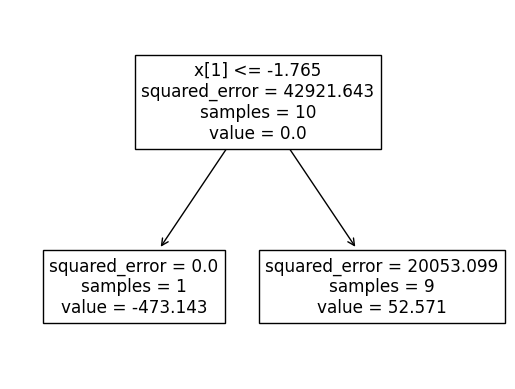

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plot_tree(tree_1)
plt.show()

**Шаг 3.**

Делаем шаг к искомой целевой переменной. Умножаем предсказание дерева на шаг (`learning rate = lr`) и прибавляем к предыдущему прогнозу.

In [ ]:
lr = 0.1

df["y_pred_1"] = df["y_pred_0"] + lr*df["tree_pred_1"]

In [ ]:
df

,feature_1,feature_2,feature_3,y_true,y_pred_0,-grad_0,tree_pred_1,y_pred_1
0,1.494079,-0.205158,0.333674,125.984193,116.101426,19.765534,52.571490,121.358575
1,0.400157,0.978738,1.764052,228.952036,116.101426,225.701219,52.571490,121.358575
2,0.121675,0.443863,0.761038,96.076073,116.101426,-40.050707,52.571490,121.358575
3,-0.151357,-0.103219,0.950088,75.633771,116.101426,-80.935310,52.571490,121.358575
4,0.144044,1.454274,0.410599,100.853619,116.101426,-30.495614,52.571490,121.358575
5,-0.854096,-2.552990,0.313068,-120.470278,116.101426,-473.143408,-473.143408,68.787085
6,0.864436,-0.742165,0.653619,93.942725,116.101426,-44.317402,52.571490,121.358575
7,1.532779,1.469359,-0.187184,139.667167,116.101426,47.131482,52.571490,121.358575
8,1.867558,-0.977278,2.240893,303.683848,116.101426,375.164844,52.571490,121.358575
9,-1.454366,0.045759,2.269755,116.691107,116.101426,1.179363,52.571490,121.358575


Видно, что для каких-то объектов стало лучше, для каких-то — хуже. Сравним общее качество после первой итерации:

In [ ]:
mse_0 = mean_squared_error(df["y_true"], df["y_pred_0"])
mse_1 = mean_squared_error(df["y_true"], df["y_pred_1"])

print(f"Iteration №0, mse: {mse_0}")
print(f"Iteration №1, mse: {mse_1}")

Iteration №0, mse: 10730.410671822861
Iteration №1, mse: 8491.763825337976


Отлично, стало лучше! Повторим шаги с 1 по 3.

**Шаг 1.**

Считаем антиградиент от последнего предсказания `y_pred_1`:

In [ ]:
df["-grad_1"] = -2*(df["y_pred_1"] - df["y_true"])

In [ ]:
df

,feature_1,feature_2,feature_3,y_true,y_pred_0,-grad_0,tree_pred_1,y_pred_1,-grad_1
0,1.494079,-0.205158,0.333674,125.984193,116.101426,19.765534,52.571490,121.358575,9.251236
1,0.400157,0.978738,1.764052,228.952036,116.101426,225.701219,52.571490,121.358575,215.186921
2,0.121675,0.443863,0.761038,96.076073,116.101426,-40.050707,52.571490,121.358575,-50.565005
3,-0.151357,-0.103219,0.950088,75.633771,116.101426,-80.935310,52.571490,121.358575,-91.449608
4,0.144044,1.454274,0.410599,100.853619,116.101426,-30.495614,52.571490,121.358575,-41.009912
5,-0.854096,-2.552990,0.313068,-120.470278,116.101426,-473.143408,-473.143408,68.787085,-378.514726
6,0.864436,-0.742165,0.653619,93.942725,116.101426,-44.317402,52.571490,121.358575,-54.831700
7,1.532779,1.469359,-0.187184,139.667167,116.101426,47.131482,52.571490,121.358575,36.617184
8,1.867558,-0.977278,2.240893,303.683848,116.101426,375.164844,52.571490,121.358575,364.650546
9,-1.454366,0.045759,2.269755,116.691107,116.101426,1.179363,52.571490,121.358575,-9.334935


**Шаг 2.**

Создаем второе дерево, учим на новом антиградиенте:

In [ ]:
tree_2 = DecisionTreeRegressor(max_depth=1)

tree_2.fit(df[["feature_1", "feature_2", "feature_3"]], df["-grad_1"])

DecisionTreeRegressor(max_depth=1)

**Шаг 3.**

Шагаем в сторону антиградиента:

In [ ]:
df["y_pred_2"] = df["y_pred_1"] + lr * tree_2.predict(df[["feature_1", "feature_2", "feature_3"]])

In [ ]:
df

,feature_1,feature_2,feature_3,y_true,y_pred_0,-grad_0,tree_pred_1,y_pred_1,-grad_1,y_pred_2
0,1.494079,-0.205158,0.333674,125.984193,116.101426,19.765534,52.571490,121.358575,9.251236,125.564294
1,0.400157,0.978738,1.764052,228.952036,116.101426,225.701219,52.571490,121.358575,215.186921,125.564294
2,0.121675,0.443863,0.761038,96.076073,116.101426,-40.050707,52.571490,121.358575,-50.565005,125.564294
3,-0.151357,-0.103219,0.950088,75.633771,116.101426,-80.935310,52.571490,121.358575,-91.449608,125.564294
4,0.144044,1.454274,0.410599,100.853619,116.101426,-30.495614,52.571490,121.358575,-41.009912,125.564294
5,-0.854096,-2.552990,0.313068,-120.470278,116.101426,-473.143408,-473.143408,68.787085,-378.514726,30.935613
6,0.864436,-0.742165,0.653619,93.942725,116.101426,-44.317402,52.571490,121.358575,-54.831700,125.564294
7,1.532779,1.469359,-0.187184,139.667167,116.101426,47.131482,52.571490,121.358575,36.617184,125.564294
8,1.867558,-0.977278,2.240893,303.683848,116.101426,375.164844,52.571490,121.358575,364.650546,125.564294
9,-1.454366,0.045759,2.269755,116.691107,116.101426,1.179363,52.571490,121.358575,-9.334935,125.564294


Сравним качество на всех итерациях:

In [ ]:
mse_1 = mean_squared_error(df["y_true"], df["y_pred_1"])
mse_2 = mean_squared_error(df["y_true"], df["y_pred_2"])

print(f"Iteration №0, mse: {mse_0}")
print(f"Iteration №1, mse: {mse_1}")
print(f"Iteration №2, mse: {mse_2}")

Iteration №0, mse: 10730.410671822861
Iteration №1, mse: 8491.763825337976
Iteration №2, mse: 7059.029843587648


Видим, что качество предсказания улучшается. Напишем цикл, чтобы можно было выбрать большее количество итераций:

In [ ]:
df = df[["feature_1", "feature_2", "feature_3", "y_true"]].copy()

In [ ]:
df

,feature_1,feature_2,feature_3,y_true
0,1.494079,-0.205158,0.333674,125.984193
1,0.400157,0.978738,1.764052,228.952036
2,0.121675,0.443863,0.761038,96.076073
3,-0.151357,-0.103219,0.950088,75.633771
4,0.144044,1.454274,0.410599,100.853619
5,-0.854096,-2.552990,0.313068,-120.470278
6,0.864436,-0.742165,0.653619,93.942725
7,1.532779,1.469359,-0.187184,139.667167
8,1.867558,-0.977278,2.240893,303.683848
9,-1.454366,0.045759,2.269755,116.691107


In [ ]:
n_estimators = 100
lr = 0.1
plot_err = []

# step 0
df["y_pred"] = df["y_true"].mean()

for i in range(n_estimators):
    # step 1
    df["-grad"] = -2*(df["y_pred"] - df["y_true"])
    # step 2
    tree = DecisionTreeRegressor(max_depth=1)
    tree.fit(df[["feature_1", "feature_2", "feature_3"]], df["-grad"])
    # step 3
    df["y_pred"] =  df["y_pred"] + lr*tree.predict(df[["feature_1", "feature_2", "feature_3"]])

    if i % (n_estimators / 10) == 0:
        mse = mean_squared_error(df["y_true"], df["y_pred"])
        print(f"Iteration №{i}, mse: {mse}")
    plot_err.append(mean_squared_error(df["y_true"], df["y_pred"]))


Iteration №0, mse: 8491.763825337976
Iteration №10, mse: 1403.2691783734049
Iteration №20, mse: 364.6348996728867
Iteration №30, mse: 144.0501552812308
Iteration №40, mse: 75.39820224483393
Iteration №50, mse: 47.16166782475665
Iteration №60, mse: 33.11280091613624
Iteration №70, mse: 23.787564570277084
Iteration №80, mse: 17.492936757257112
Iteration №90, mse: 13.183725635079167


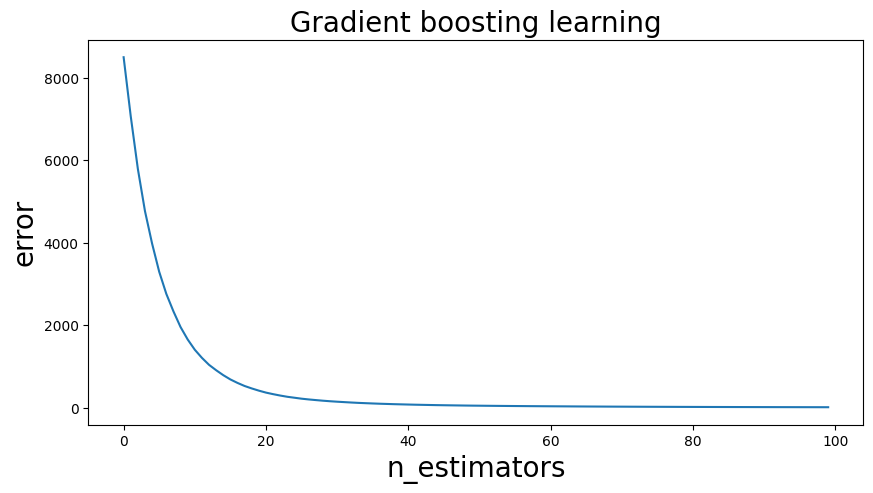

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Gradient boosting learning", fontsize=20)
plt.plot(plot_err)
plt.ylabel("error", fontsize=20)
plt.xlabel("n_estimators", fontsize=20)
plt.show()